# Introduzione

Questo semplice Notebook cerca di darvi una rappresentazione dei dati grezzi scaricati dalla repository ufficiale della [Protezione Civile](https://github.com/pcm-dpc).
Una volta scaricati i dati nella location di vostra preferenza dovrete sostituire, nella seconda cella, _fake path_ con il path della vostra cartella (ad esempio, se copierete i dati in C:\Pinco Pallino allora il path del file diverrà: _C:\Pinco Pallino\COVID-19\dati-andamento-nazionale\dpc-covid19-ita-andamento-nazionale.csv_).
Una volta che avrete settato questa variabile correttamente ed installate le librerie ove non siano presenti, il Notebook vi restituirà una stima aggiornata del modello ai nuovi dati.

Importiamo le librerie

In [ ]:
import numpy as np
import pandas as pd
import os

Settiamo il path al file _dpc-covid19-ita-andamento-nazionale.csv_

In [2]:
covid_data = pd.read_csv("fake_path")

Calcoliamo le variabili:
* tamponi_giornalieri (dato che viene fornito solo il numero cumulativo dei tamponi)
* positivi/tamponi
* Terapia Intensiva/Ricoverati con Sintomi
* data (tenendo come data solo _YYYY-MM-DD_ e non l'orario _Thh:mm:ss:dd_)

In [3]:
covid_data["tamponi_giornalieri"] = covid_data["tamponi"] - covid_data["tamponi"].shift(1)
covid_data["positivi/tamponi"] = (covid_data["nuovi_positivi"] / covid_data["tamponi_giornalieri"]) * 100
covid_data["Terapia Intensiva/Ricoverati con Sintomi"] = (covid_data["terapia_intensiva"] / covid_data["ricoverati_con_sintomi"]) * 100
covid_data["data"] = covid_data["data"].str.split("T", expand=True)[0]
covid_data.set_index("data", inplace=True)

<AxesSubplot:title={'center':'Indice Positivi per Tamponi (LogScale)'}, xlabel='Data', ylabel='Tamponi'>

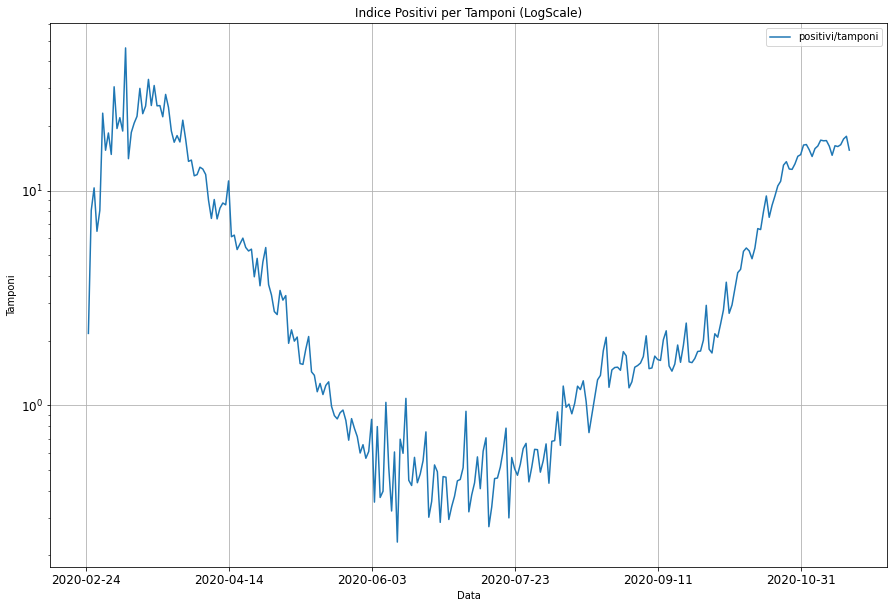

In [4]:
plot_kwargs={
    "grid": True, 
    "fontsize": 12, 
    "logy": True, 
    "use_index": True, 
    "xlabel": "Data", 
    "ylabel": "Tamponi", 
    "title": "Indice Positivi per Tamponi (LogScale)", 
    "figsize": (15,10)
}
covid_data.plot.line(y="positivi/tamponi", **plot_kwargs)

<AxesSubplot:title={'center':'Numero di Decessi (LogScale)'}, xlabel='Data'>

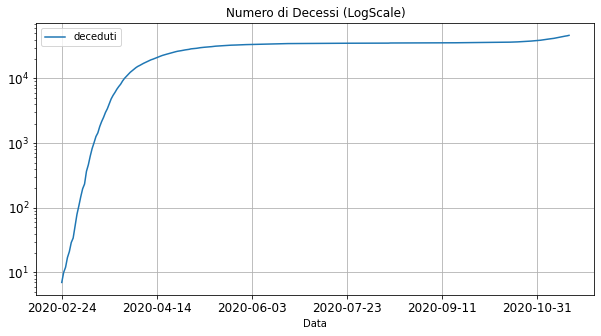

In [5]:
plot_kwargs = {
    "grid": True, 
    "fontsize": 12, 
    "logy": True, 
    "use_index": True, 
    "xlabel": "Data", 
    "title": "Numero di Decessi (LogScale)", 
    "figsize": (10,5)
}
covid_data.plot(y="deceduti", **plot_kwargs)

<AxesSubplot:title={'center':'Terapia Intensiva / Ricoverati con Sintomi (LogScale)'}, xlabel='Data'>

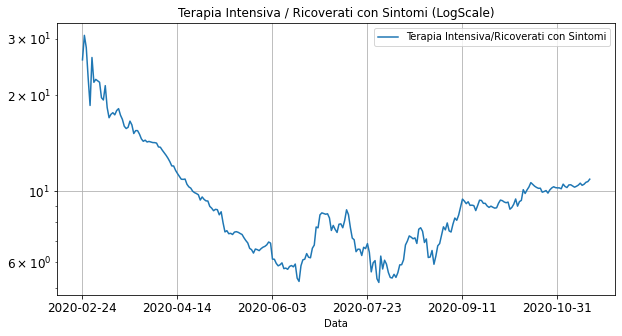

In [6]:
plot_kwargs = {
    "grid": True, 
    "fontsize": 12, 
    "logy": True, 
    "use_index": True, 
    "xlabel": "Data",
    "title": "Terapia Intensiva / Ricoverati con Sintomi (LogScale)", 
    "figsize": (10,5)
}
covid_data.plot(y="Terapia Intensiva/Ricoverati con Sintomi", **plot_kwargs)

In [7]:
covid_data["isolamento_domiciliare"] / covid_data["totale_positivi"]

data
2020-02-24    0.425339
2020-02-25    0.520900
2020-02-26    0.574026
2020-02-27    0.482993
2020-02-28    0.501827
                ...   
2020-11-13    0.948573
2020-11-14    0.949590
2020-11-15    0.950218
2020-11-16    0.949807
2020-11-17    0.950006
Length: 268, dtype: float64

<AxesSubplot:xlabel='data'>

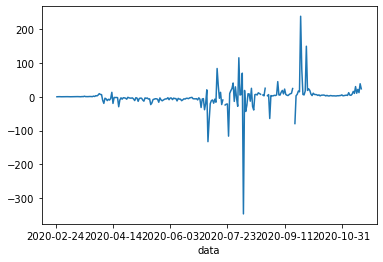

In [8]:
variazione_ospedalizzati = covid_data["totale_ospedalizzati"] - covid_data["totale_ospedalizzati"].shift(1)
variazione_dimessi_guariti = covid_data["dimessi_guariti"] - covid_data["dimessi_guariti"].shift(1)
(variazione_dimessi_guariti / variazione_ospedalizzati).plot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

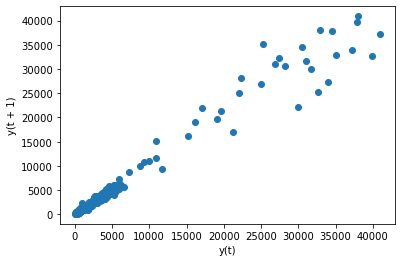

In [9]:
from pandas.plotting import lag_plot
lag_plot(covid_data["nuovi_positivi"])

## Modello

Cominciamo con importare le librerie richieste per lavorare con il modello autoregressivo.
Creiamo due liste, _train_ e _test_:
* **train** ci servirà per stimare i parametri del modello
* **test** ci servirà per testare l'efficacia del nostro modello [_out of sample_](https://it.wikipedia.org/wiki/Convalida_incrociata). In questo caso, i dati su cui validare il nostro modello sono 7

Dopo aver creto le due liste, stimato il modello, non ci resta che verificarne l'efficacia usando come indicatore di precisione l'_RMSE_ (dall'inglese [_Root Mean Square Error_](https://en.wikipedia.org/wiki/Root-mean-square_deviation). La funzione _mse_optimizer_ avrà il compito di stimare qual è il valore minimo di RMSE per ogni ritardo (_lag_) del modello autoregressivo e di ritornare il valore di _lag_ che restituisce il minor _RMSE_ (minimizzando l'errore, dunque).
Una volta calcolato il valore minimo di _RMSE_, il corrispondente numero di _lag_ è usato per stimare il modello e usarlo per prevedere l'andamento della serie numerica.

In [10]:
# Setup optimization function

from statsmodels.tsa.ar_model import AutoReg

def mse_optimizer(lags, train, test):
    optimal_number_of_lags = 0
    lowest_rmse = np.inf
    for i in range(1, lags):
        model = AutoReg(train, lags=i, old_names=False)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
        rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
        lowest_rmse
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            optimal_number_of_lags = i
    print(f"Chosen number of lags: {optimal_number_of_lags} with RMSE: {lowest_rmse}")
    return optimal_number_of_lags

In [11]:
# Prediction model

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = np.log(covid_data["nuovi_positivi"])
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

In [12]:
# train autoregression
optimal_number_of_lags = mse_optimizer(100, train, test)
model = AutoReg(train, lags=optimal_number_of_lags, old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Chosen number of lags: 15 with RMSE: 1385.104630532246
Coefficients: [ 0.08828507  0.39515113  0.25165336  0.23404672  0.02716273  0.02163165
  0.29246524  0.2736414   0.02727637 -0.2594003  -0.18468387 -0.10860381
 -0.02934075  0.04171907  0.07509135 -0.06999205]


In [13]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (np.exp(predictions[i]), np.exp(test[i])))
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print('Test RMSE: %.3f' % rmse)
kwargs = {
    "start": len(series),
    "end": len(series) + 2
}
predicted_values = np.exp(model_fit.predict(**kwargs))
predicted_values

predicted=34241.541220, expected=32961.000000
predicted=36807.551516, expected=37978.000000
predicted=40999.628122, expected=40902.000000
predicted=38699.197823, expected=37255.000000
predicted=32319.306391, expected=33979.000000
predicted=29476.341760, expected=27354.000000
predicted=31158.666542, expected=32191.000000
Test RMSE: 1385.105


array([35260.31920459, 36694.00397289, 34090.2145369 ])

/Users/leonardourbano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


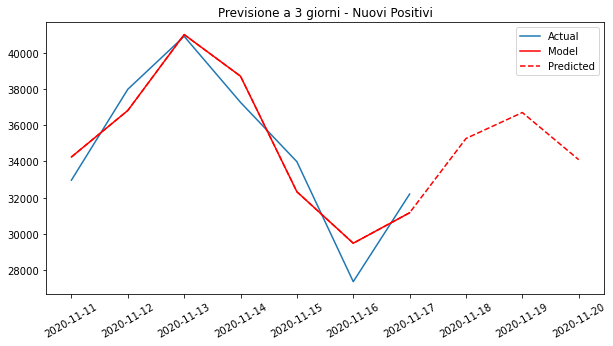

In [14]:
# plot results
date_range = pd.date_range(start=covid_data.index[-7:][0], periods=10)
fig = pyplot.figure(figsize=(10,5))
pyplot.plot(date_range[:7], np.exp(test))
pyplot.plot(date_range[:7], np.exp(predictions), color='red')
pyplot.plot(date_range, np.array(list(np.exp(predictions)) + list(predicted_values)), color='red', linestyle="--")
pyplot.legend(("Actual", "Model", "Predicted"))
pyplot.xticks(rotation=30)
pyplot.title("Previsione a 3 giorni - Nuovi Positivi")
fig.show()

In [15]:
# Prediction model

from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = np.log(covid_data["positivi/tamponi"])
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

In [16]:
# train autoregression
optimal_number_of_lags = mse_optimizer(100, train, test)
model = AutoReg(train, lags=optimal_number_of_lags, old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Chosen number of lags: 30 with RMSE: 0.6673508478554453
Coefficients: [ 0.01930816  0.19822537  0.35414385  0.18348914  0.02001859  0.08632223
  0.23375356  0.27623481 -0.05660211 -0.25781306  0.04682887  0.0739084
 -0.048179   -0.10472693  0.16434126  0.09801774 -0.05779373 -0.04009085
 -0.01093664 -0.12137687 -0.00798151  0.09545051 -0.08090536 -0.04935919
 -0.14658156 -0.00494717  0.01449404  0.0546253   0.14657939 -0.09655999
  0.01057479]


In [17]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (np.exp(predictions[i]), np.exp(test[i])))
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print('Test RMSE: %.3f' % rmse)
kwargs = {
    "start": len(series),
    "end": len(series) + 2
}
predicted_values = np.exp(model_fit.predict(**kwargs))
predicted_values

predicted=15.374663, expected=14.607782
predicted=16.105571, expected=16.183439
predicted=17.073810, expected=16.045789
predicted=16.414328, expected=16.361800
predicted=17.324700, expected=17.400589
predicted=16.736227, expected=17.917898
predicted=15.194168, expected=15.442439
Test RMSE: 0.667


array([14.87867688, 15.1749457 , 14.99100318])

/Users/leonardourbano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


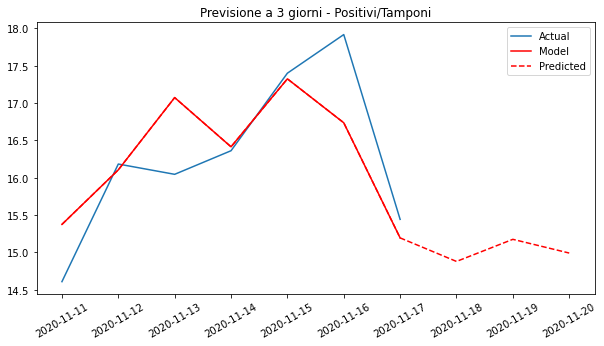

In [18]:
# plot results
date_range = pd.date_range(start=covid_data.index[-7:][0], periods=10)
fig = pyplot.figure(figsize=(10,5))
pyplot.plot(date_range[:7], np.exp(test))
pyplot.plot(date_range[:7], np.exp(predictions), color='red')
pyplot.plot(date_range, np.array(list(np.exp(predictions)) + list(predicted_values)), color='red', linestyle="--")
pyplot.legend(("Actual", "Model", "Predicted"))
pyplot.xticks(rotation=30)
pyplot.title("Previsione a 3 giorni - Positivi/Tamponi")
fig.show()

In [19]:
date_range = covid_data.index[-8:]
pd.date_range(start=covid_data.index[-7:][0], periods=10)

DatetimeIndex(['2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20'],
              dtype='datetime64[ns]', freq='D')

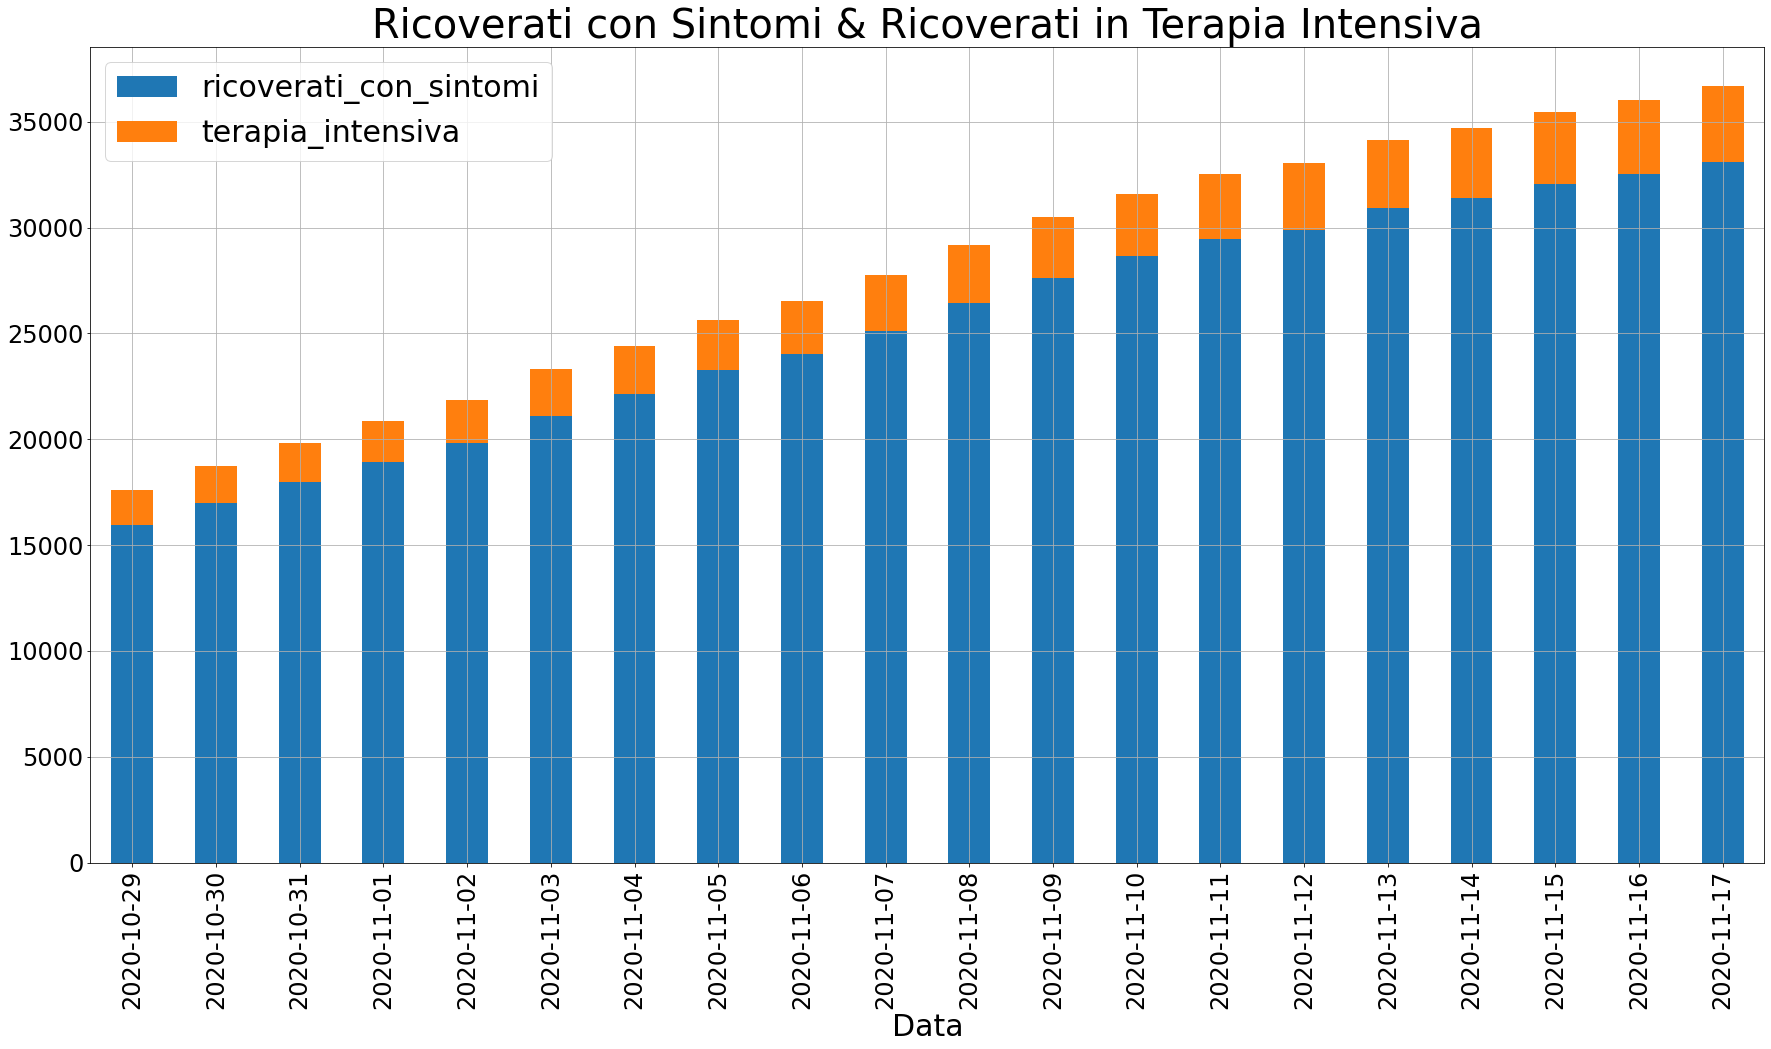

In [20]:
kwargs = {
    "kind": "bar",
    "grid": True,
    "rot": 90,
    "figsize": (30,15),
    "fontsize": 24,
    "stacked": True
}
covid_data[["ricoverati_con_sintomi", "terapia_intensiva"]].iloc[-20:].plot(**kwargs)
pyplot.legend(loc='upper left', prop={'size': 30})
pyplot.title("Ricoverati con Sintomi & Ricoverati in Terapia Intensiva", fontdict={'fontsize': 40})
pyplot.xlabel("Data", fontdict={'fontsize': 30})
pyplot.show()

Text(0.5, 0, 'Giorni')

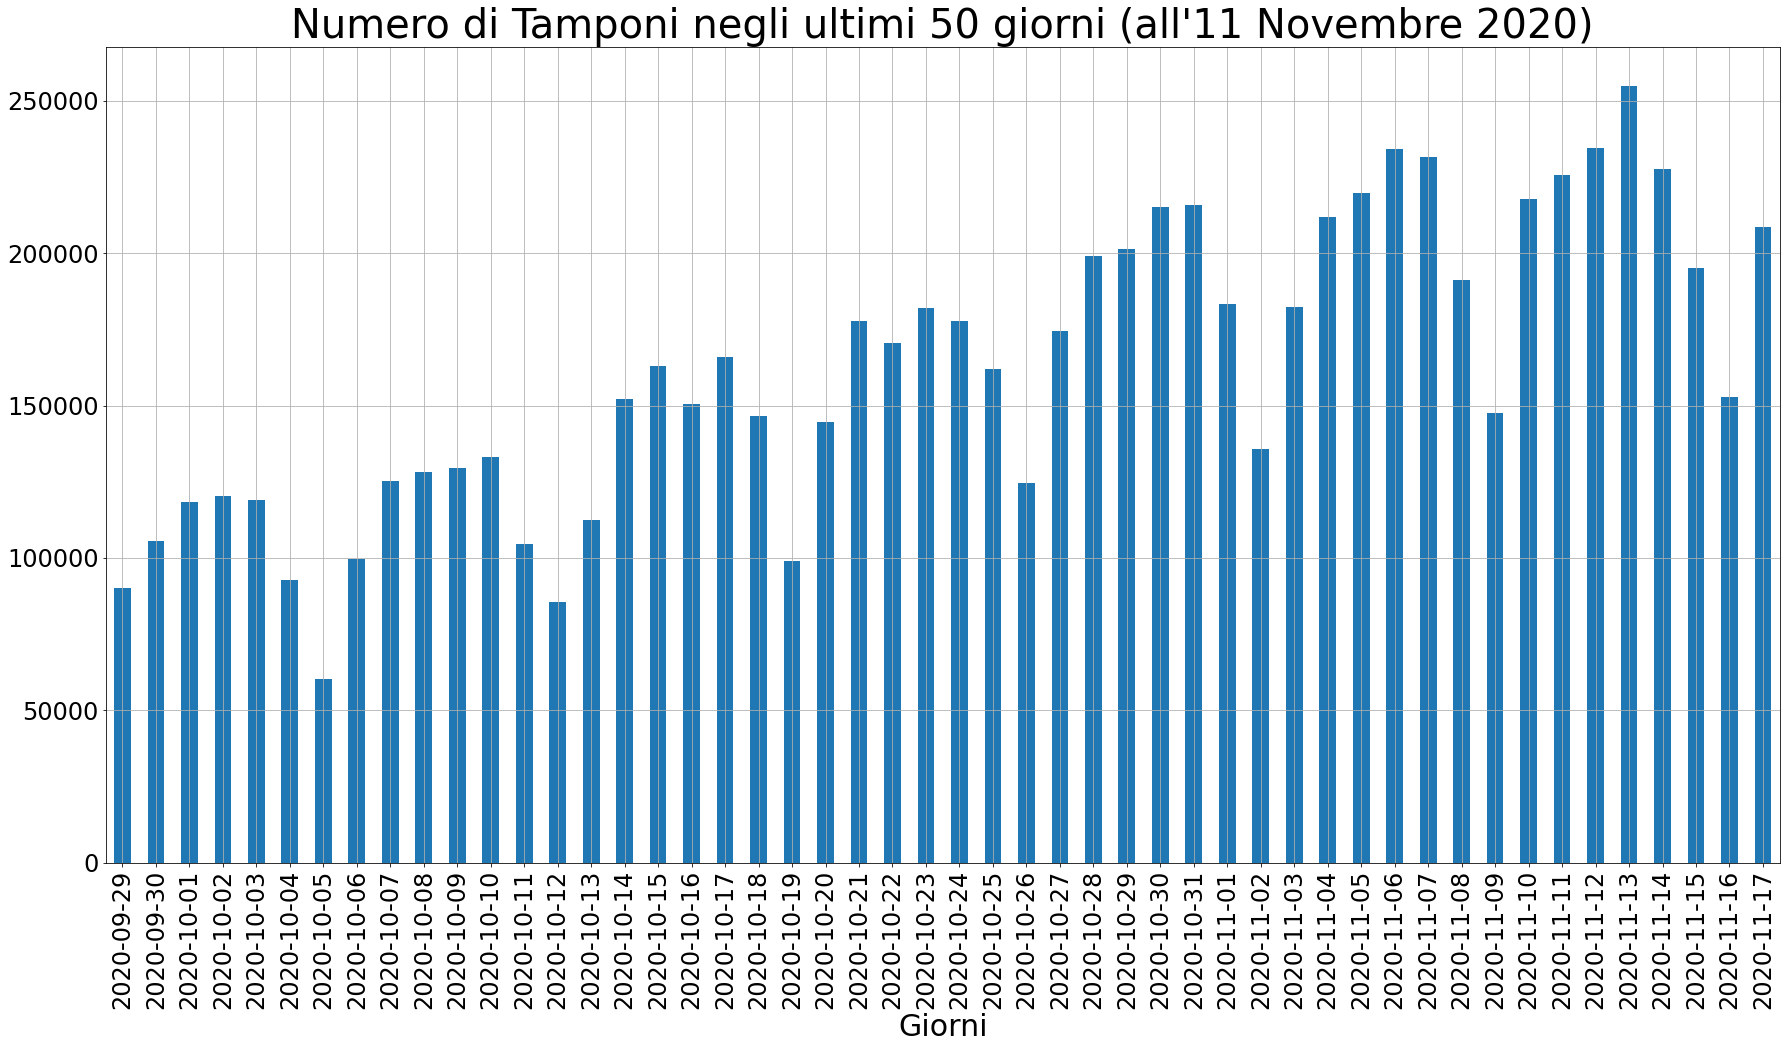

In [21]:
kwargs = {
    "kind": "bar",
    "figsize": (30,15),
    "grid": True,
    "fontsize": 24,
}
pyplot.title("Numero di Tamponi negli ultimi 50 giorni (all'11 Novembre 2020)", fontdict={'fontsize': 40})
covid_data["tamponi_giornalieri"].iloc[-50:].plot(**kwargs).set_xlabel("Giorni", fontdict={'fontsize': 30})

In [22]:
df = pd.DataFrame({
    "nuovi_positivi": covid_data["nuovi_positivi"].tolist(),
    "nuovi_positivi_t+1": covid_data["nuovi_positivi"].shift(1).tolist()
}, index=covid_data.index.tolist())
df

,nuovi_positivi,nuovi_positivi_t+1
2020-02-24,221,NaN
2020-02-25,93,221.0
2020-02-26,78,93.0
2020-02-27,250,78.0
2020-02-28,238,250.0
...,...,...
2020-11-13,40902,37978.0
2020-11-14,37255,40902.0
2020-11-15,33979,37255.0
2020-11-16,27354,33979.0


Text(0, 0.5, '% di Positivi')

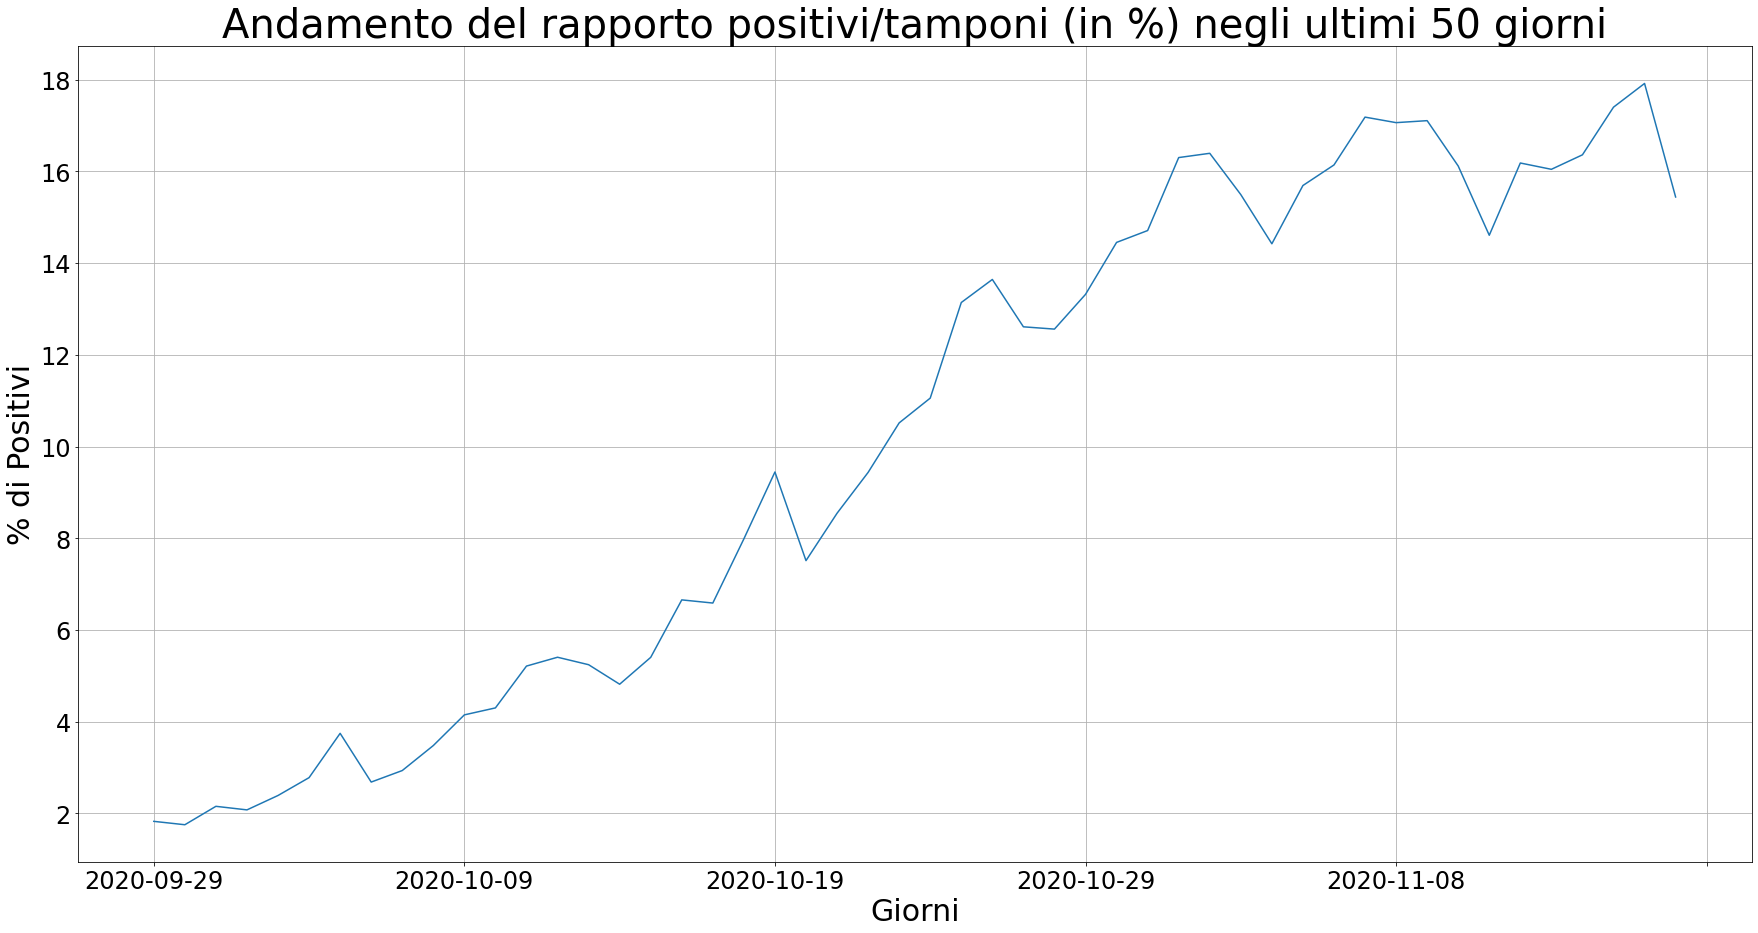

In [23]:
kwargs = {
    "figsize": (30,15),
    "grid": True,
    "fontsize": 24,
}
pyplot.title("Andamento del rapporto positivi/tamponi (in %) negli ultimi 50 giorni", fontdict={'fontsize': 40})
fig = covid_data["positivi/tamponi"].iloc[-50:].plot(**kwargs)
fig.set_xlabel("Giorni", fontdict={'fontsize': 30})
fig.set_ylabel("% di Positivi", fontdict={'fontsize': 30})

Text(0.5, 1.0, 'Variazione % di Log(Dati Grezzi)')

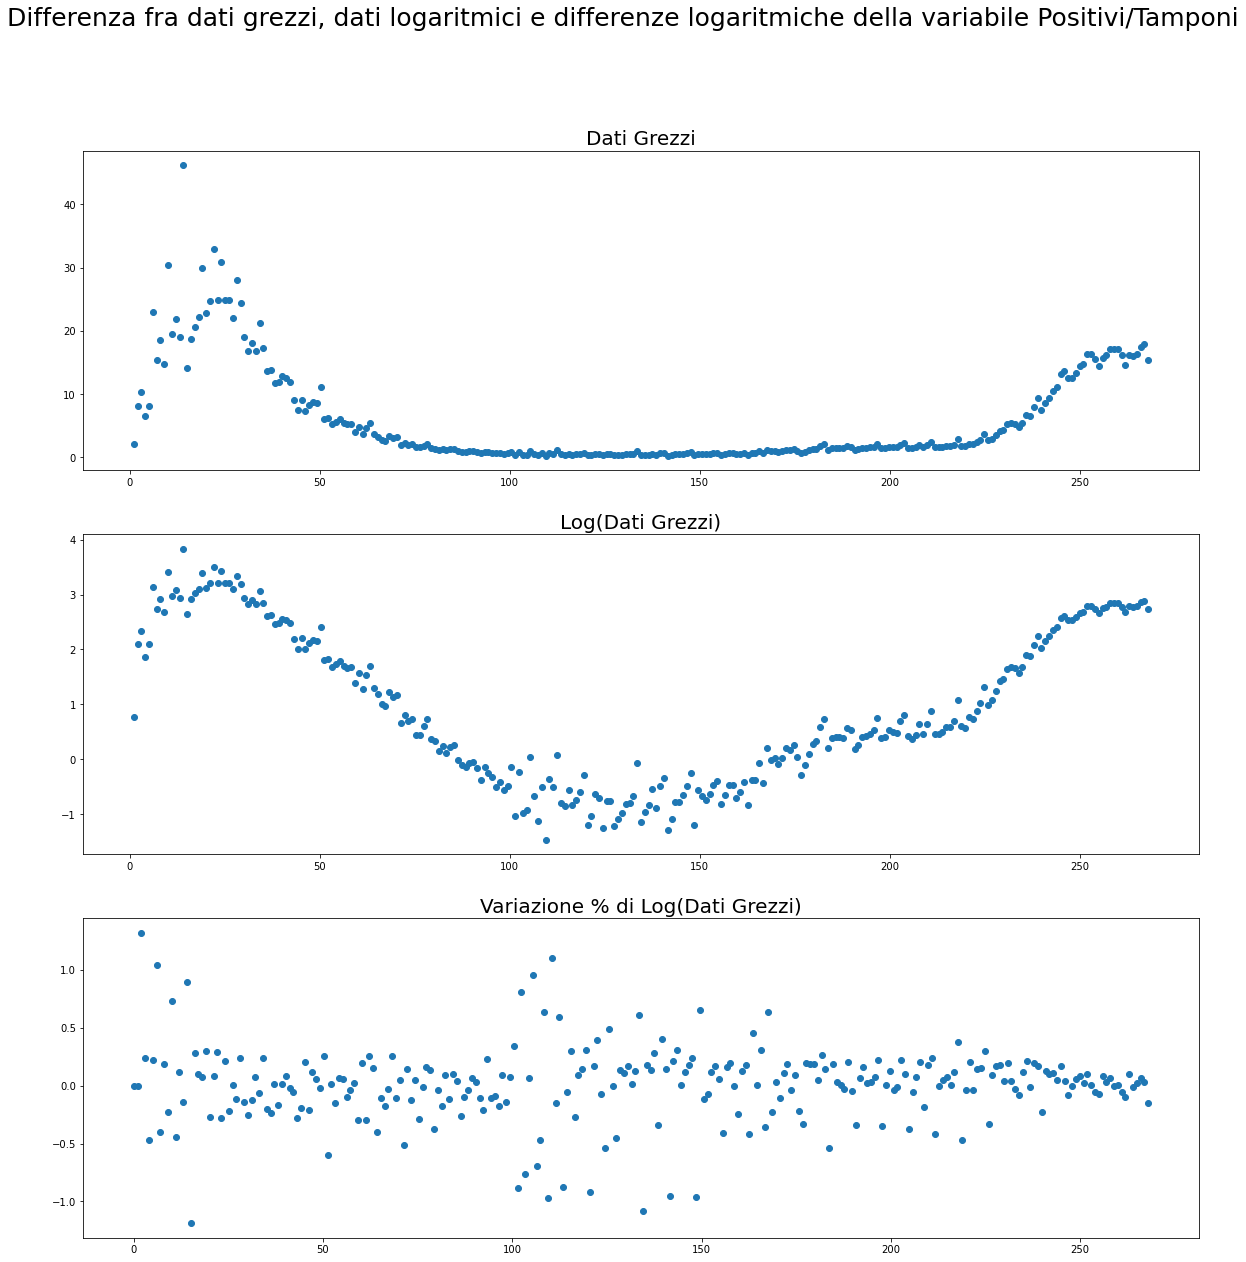

In [24]:
fig, axs = pyplot.subplots(3, figsize=(20,20))
fig.suptitle('Differenza fra dati grezzi, dati logaritmici e differenze logaritmiche della variabile Positivi/Tamponi', fontsize=25)
log_p_t = np.log(covid_data["positivi/tamponi"])
diff_log_p_t = log_p_t - log_p_t.shift(1)
series = diff_log_p_t.fillna(0)
numbers = np.linspace(0,len(covid_data["positivi/tamponi"]), num=len(covid_data["positivi/tamponi"]))
axs[0].scatter(numbers, covid_data["positivi/tamponi"])
axs[0].set_title("Dati Grezzi", fontsize=20)
axs[1].scatter(numbers, np.log(covid_data["positivi/tamponi"]))
axs[1].set_title("Log(Dati Grezzi)", fontsize=20)
axs[2].scatter(numbers, series)
axs[2].set_title("Variazione % di Log(Dati Grezzi)", fontsize=20)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

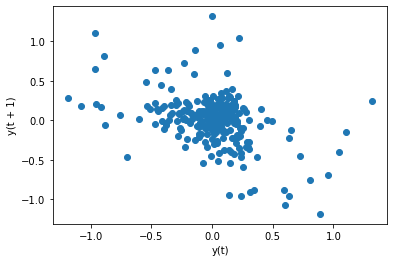

In [25]:
lag_plot(series)